In [1]:
import pandas as pd
import os
from skimpy import skim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def read_ratings(ratings_csv: str, data_dir: str = "/home/antoine/Ml_Ops_Movies_Reco/src/data/data/raw") -> pd.DataFrame:
    """
    Lit le fichier CSV contenant les évaluations des films.

    :param ratings_csv: Nom du fichier CSV contenant les évaluations.
    :param data_dir: Répertoire où se trouve le fichier CSV.
    :return: DataFrame contenant les évaluations.
    """
    data = pd.read_csv(os.path.join(data_dir, ratings_csv))
    print("Dataset ratings chargé")
    return data

def read_movies(movies_csv: str, data_dir: str = "/home/antoine/Ml_Ops_Movies_Reco/src/data/data/raw") -> pd.DataFrame:
    """
    Lit le fichier CSV contenant les informations sur les films.

    :param movies_csv: Nom du fichier CSV contenant les informations sur les films.
    :param data_dir: Répertoire où se trouve le fichier CSV.
    :return: DataFrame contenant les informations sur les films.
    """
    df = pd.read_csv(os.path.join(data_dir, movies_csv))
    print("Dataset movies chargé")
    return df

L'ensemble de données des films doit être nettoyé de deux manières :
- les genres sont exprimés sous forme de chaîne avec un pipe
- le titre contient actuellement (année) ajouté à la fin. Nous allons extraire l'année de chaque chaîne de titre et créer une nouvelle colonne pour celle-ci.

In [23]:
movies = read_movies('movies.csv')
# Split sur les pipes
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
# Extraction de l'année et mise à jour du titre
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')[0]
movies['title'] = movies['title'].str.replace(r' \(\d{4}\)', '', regex=True)
movies.fillna(method='ffill', inplace= True)
movies.head()

Dataset movies chargé


/tmp/ipykernel_16036/900422629.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  movies.fillna(method='ffill', inplace= True)


,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [24]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
 3   year     27278 non-null  object
dtypes: int64(1), object(3)
memory usage: 852.6+ KB


In [4]:
# Calcul du nombre de genres
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"Il y a  {len(genre_frequency)} genres.")

genre_frequency

Il y a  20 genres.


Counter({'Drama': 13344,
         'Comedy': 8374,
         'Thriller': 4178,
         'Romance': 4127,
         'Action': 3520,
         'Crime': 2939,
         'Horror': 2611,
         'Documentary': 2471,
         'Adventure': 2329,
         'Sci-Fi': 1743,
         'Mystery': 1514,
         'Fantasy': 1412,
         'War': 1194,
         'Children': 1139,
         'Musical': 1036,
         'Animation': 1027,
         'Western': 676,
         'Film-Noir': 330,
         '(no genres listed)': 246,
         'IMAX': 196})

In [5]:
# Genres les plus représentés:
print("Les 5 genres les plus représentés sont : \n", genre_frequency.most_common(5))

Les 5 genres les plus représentés sont : 
 [('Drama', 13344), ('Comedy', 8374), ('Thriller', 4178), ('Romance', 4127), ('Action', 3520)]


/tmp/ipykernel_26525/3865811001.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False), palette='viridis')


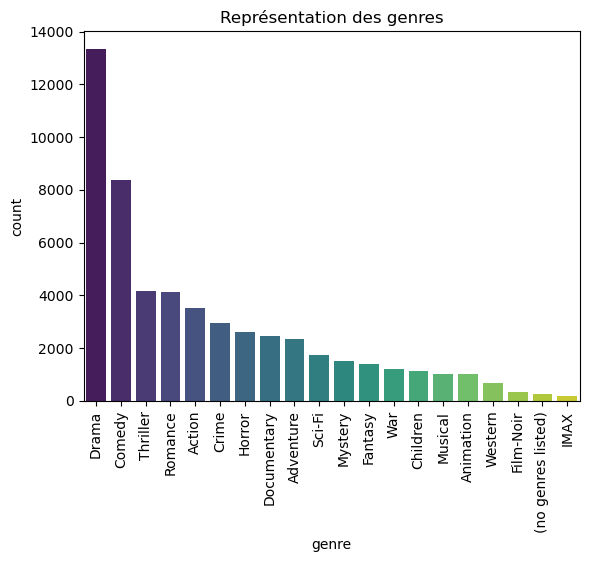

In [7]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False), palette='viridis')
plt.xticks(rotation=90)
plt.title("Représentation des genres")
plt.show()

Nous allons utiliser une technique appelée filtrage collaboratif pour générer des recommandations pour les utilisateurs. Cette technique repose sur le principe selon lequel des personnes similaires aiment des choses similaires. La première étape consiste à transformer nos données en une matrice utilisateur-élément, également appelée matrice « utilitaire ». Dans cette matrice, les lignes représentent les utilisateurs et les colonnes représentent les films. L'avantage du filtrage collaboratif est qu'il ne nécessite aucune information sur les utilisateurs ou sur l'utilisateur des films pour générer des recommandations.

Nous créons une fonction create_X() qui génère une matrice creuse avec quatre dictionnaires de mappage :

- user_mapper : mappe l'ID utilisateur à l'index utilisateur
- movie_mapper : mappe l'ID du film à l'index du film
- user_inv_mapper : mappe l'index utilisateur à l'ID utilisateur
- movie_inv_mapper : mappe l'index du film à l'ID du film

Nous avons besoin de ces dictionnaires car ils mappent quelle ligne/colonne de la matrice utilitaire correspond à quel ID utilisateur/film.

In [8]:
from scipy.sparse import csr_matrix
from scipy import sparse

def create_X(df):
    """
    Génère une matrice creuse avec quatre dictionnaires de mappage
    - user_mapper: mappe l'ID utilisateur à l'index utilisateur
    - movie_mapper: mappe l'ID du film à l'index du film
    - user_inv_mapper: mappe l'index utilisateur à l'ID utilisateur
    - movie_inv_mapper: mappe l'index du film à l'ID du film
    Args:
        df: pandas dataframe contenant 3 colonnes (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    # Sauvegarder la matrice creuse dans un fichier
    sparse.save_npz('sparse_matrix.npz', X)

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper


In [9]:
ratings = read_ratings('ratings.csv')

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

Dataset ratings chargé


In [23]:
# Afficher la forme de la matrice creuse
print("Shape de la matrice creuse X :", X.shape)

# Afficher quelques éléments non nuls de la matrice
print("\nÉléments non nuls dans la matrice creuse :")
print(X.nonzero())  # Affiche les indices des éléments non nuls
print(X.data[:10])  # Affiche les 10 premières notes

Shape de la matrice creuse X : (138493, 26744)

Éléments non nuls dans la matrice creuse :
(array([     0,      0,      0, ..., 138492, 138492, 138492], dtype=int32), array([    1,    28,    31, ..., 13875, 13993, 14277], dtype=int32))
[3.5 3.5 3.5 3.5 3.5 3.5 4.  4.  4.  4. ]


In [24]:
# Afficher un aperçu des mappers
print("\nAperçu du user_mapper (premiers 5 utilisateurs) :")
for user_id, index in list(user_mapper.items())[:5]:
    print(f"User ID: {user_id} -> Index: {index}")

print("\nAperçu du movie_mapper (premiers 5 films) :")
for movie_id, index in list(movie_mapper.items())[:5]:
    print(f"Movie ID: {movie_id} -> Index: {index}")

print("\nAperçu du user_inv_mapper (premiers 5 indices utilisateurs) :")
for index, user_id in list(user_inv_mapper.items())[:5]:
    print(f"Index: {index} -> User ID: {user_id}")

print("\nAperçu du movie_inv_mapper (premiers 5 indices films) :")
for index, movie_id in list(movie_inv_mapper.items())[:5]:
    print(f"Index: {index} -> Movie ID: {movie_id}")


Aperçu du user_mapper (premiers 5 utilisateurs) :
User ID: 1 -> Index: 0
User ID: 2 -> Index: 1
User ID: 3 -> Index: 2
User ID: 4 -> Index: 3
User ID: 5 -> Index: 4

Aperçu du movie_mapper (premiers 5 films) :
Movie ID: 1 -> Index: 0
Movie ID: 2 -> Index: 1
Movie ID: 3 -> Index: 2
Movie ID: 4 -> Index: 3
Movie ID: 5 -> Index: 4

Aperçu du user_inv_mapper (premiers 5 indices utilisateurs) :
Index: 0 -> User ID: 1
Index: 1 -> User ID: 2
Index: 2 -> User ID: 3
Index: 3 -> User ID: 4
Index: 4 -> User ID: 5

Aperçu du movie_inv_mapper (premiers 5 indices films) :
Index: 0 -> Movie ID: 1
Index: 1 -> Movie ID: 2
Index: 2 -> Movie ID: 3
Index: 3 -> Movie ID: 4
Index: 4 -> Movie ID: 5


Nous avons 138493 users et 26744 films

Esnuite, nous calculons la parcimonie en divisant le nombre d'éléments stockés par le nombre total d'éléments. Le nombre d'éléments stockés (non vides) dans notre matrice (nnz) est équivalent au nombre de notes dans notre ensemble de données.

In [12]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.54%


csr_matrix.nnz compte les valeurs stockées dans notre matrice. Le reste de nos cellules sont vides.

Le problème de démarrage à froid se produit lorsqu'il y a de nouveaux utilisateurs et films dans notre matrice qui n'ont aucune note. Dans notre ensemble de données, tous les utilisateurs et films ont au moins une note, mais il est utile de vérifier quels utilisateurs et films ont peu d'interactions.

In [13]:
n_ratings_per_user = X.getnnz(axis=1)
print(f"L'utilisateur le plus actif a noté {n_ratings_per_user.max()} films.")
print(f"Le moins actif en a noté {n_ratings_per_user.min()}")

L'utilisateur le plus actif a noté 9254 films.
Le moins actif en a noté 20


In [14]:
n_ratings_per_movie = X.getnnz(axis=0)
print(f"Le film le plus noté a obtenu {n_ratings_per_movie.max()} vote.")
print(f"Le moins noté en a obtenu {n_ratings_per_movie.min()}.")

Le film le plus noté a obtenu 67310 vote.
Le moins noté en a obtenu 1.


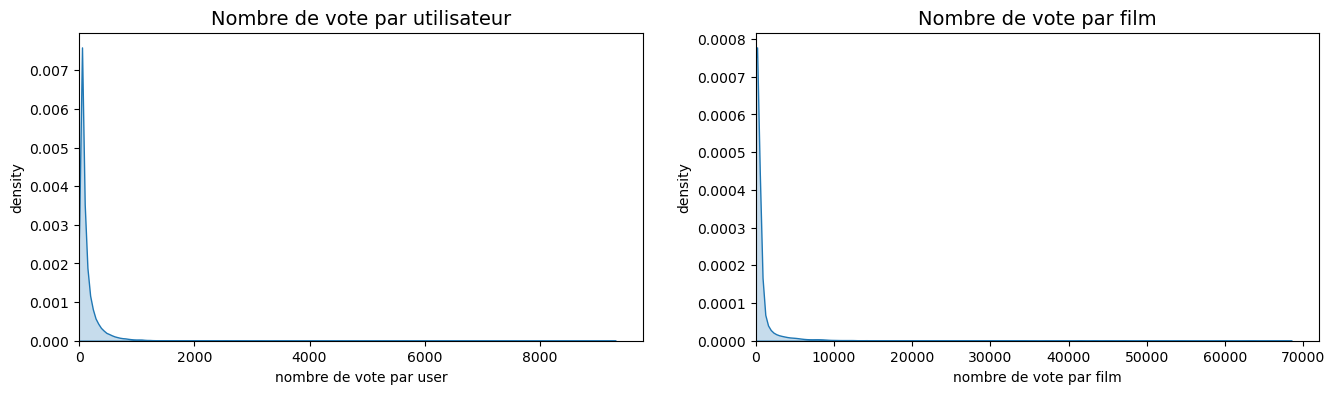

In [17]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Nombre de vote par utilisateur", fontsize=14)
plt.xlabel("nombre de vote par user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Nombre de vote par film", fontsize=14)
plt.xlabel("nombre de vote par film")
plt.ylabel("density")
plt.show();


### Recommendations avec KNN

Nous allons trouver les 𝑘 films qui ont les vecteurs d'engagement des utilisateurs les plus similaires pour un film donné .

In [10]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Trouve les k voisins les plus proches pour un ID de film donné.

    Args:
        movie_id: ID du film d'intérêt
        X: matrice d'utilité utilisateur-article (matrice creuse)
        k: nombre de films similaires à récupérer
        metric: métrique de distance pour les calculs kNN

    Output: retourne une liste des k ID de films similaires
    """
    # Transposer la matrice X pour que les films soient en lignes et les utilisateurs en colonnes
    X = X.T
    neighbour_ids = []  # Liste pour stocker les ID des films similaires

    # Obtenir l'index du film à partir du mapper
    movie_ind = movie_mapper[movie_id]

    # Extraire le vecteur correspondant au film spécifié
    movie_vec = X[movie_ind]

    # Vérifier si movie_vec est un tableau NumPy et le remodeler en 2D si nécessaire
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1, -1)  # Reshape pour avoir une forme (1, n_features)

    # Initialiser NearestNeighbors avec k+1 car nous voulons inclure le film lui-même dans les voisins
    kNN = NearestNeighbors(n_neighbors=k + 1, algorithm="brute", metric=metric)

    # Ajuster le modèle sur la matrice transposée (films comme lignes)
    kNN.fit(X)

    # Trouver les k+1 voisins les plus proches (y compris le film d'intérêt)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)

    # Collecter les ID des films parmi les voisins trouvés
    for i in range(0, k):  # Boucler jusqu'à k pour obtenir seulement les films similaires
        n = neighbour.item(i)  # Obtenir l'index du voisin
        neighbour_ids.append(movie_inv_mapper[n])  # Mapper l'index à l'ID du film

    neighbour_ids.pop(0)  # Retirer le premier élément qui est l'ID du film original

    return neighbour_ids  # Retourner la liste des ID de films similaires

In [11]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[260, 780, 1210, 3114, 1270, 356, 588, 648, 480]

In [35]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Star Wars: Episode IV - A New Hope (1977)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode VI - Return of the Jedi (1983)
Toy Story 2 (1999)
Back to the Future (1985)
Forrest Gump (1994)
Aladdin (1992)
Mission: Impossible (1996)
Jurassic Park (1993)


Les résultats ci-dessus montrent les 10 films les plus similaires à Toy Story. La plupart des films de cette liste sont des films familiaux des années 1990, ce qui démontre une certaine performance de notre modèle. Ces recommandations sont basées uniquement sur les notes des utilisateurs. Les caractéristiques des films telles que les genres ne sont pas utilisées dans cette approche. Nous pouvons également jouer avec la mesure de distance kNN et voir les résultats obtenus en utilsant « Manhattan » ou « Euclidien » au lieu de « Cosinus ».

In [36]:
# metric Euclidiean
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Willy Wonka & the Chocolate Factory (1971)
Independence Day (a.k.a. ID4) (1996)
Mission: Impossible (1996)
Twister (1996)
Bug's Life, A (1998)
Men in Black (a.k.a. MIB) (1997)
Monsters, Inc. (2001)
Groundhog Day (1993)


In [37]:
# metric Manhattan
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='manhattan', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Willy Wonka & the Chocolate Factory (1971)
Bug's Life, A (1998)
Monsters, Inc. (2001)
Mission: Impossible (1996)
Finding Nemo (2003)
Independence Day (a.k.a. ID4) (1996)
Twister (1996)
Men in Black (a.k.a. MIB) (1997)


### Problème du "démarrage à froid"

Le filtrage collaboratif repose uniquement sur les interactions utilisateur-élément au sein de la matrice d'utilité. Le problème avec cette approche est que les nouveaux utilisateurs ou les éléments sans itération sont exclus du système de recommandation. C'est ce qu'on appelle le problème du démarrage à froid. Le filtrage basé sur le contenu est un moyen de gérer ce problème en générant des recommandations basées sur les caractéristiques de l'utilisateur et de l'élément.

Tout d'abord, nous devons convertir la colonne des genres en caractéristiques binaires. Chaque genre aura sa propre colonne dans le dataframe et sera renseigné avec 0 ou 1.

In [9]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 27278 unique movies in our movies dataset.


In [36]:
# Extraction des genres
genres = set(g for G in movies['genres'] for g in G)

# Création des colonnes pour chaque genre
for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))

# Normalisation de l'année (par exemple, Min-Max)
movies['year'] = movies['year'].astype(int)

movies['year_normalized'] = (movies['year'] - movies['year'].min()) / (movies['year'].max() - movies['year'].min())

# Création d'un DataFrame avec les genres et l'année normalisée
movie_features = movies.drop(columns=['movieId', 'title', 'genres', 'year', '(no genres listed)'])
movie_features['year_normalized'] = movies['year_normalized']

In [37]:
# genres = set(g for G in movies['genres'] for g in G)

# for g in genres:
#     movies[g] = movies.genres.transform(lambda x: int(g in x))

# # Extraction des années uniques
# years = set(movies['year'])

# # Création des colonnes pour chaque année
# for y in years:
#     movies[y] = movies['year'].transform(lambda x: int(x == y))

# movie_genres = movies.drop(columns=['movieId', 'title','genres', 'year', '(no genres listed)'])

In [38]:
movie_features.head()

,Romance,Musical,Film-Noir,IMAX,Documentary,Western,Horror,Children,Adventure,Comedy,Action,War,Drama,Fantasy,Thriller,Sci-Fi,Animation,Crime,Mystery,year_normalized
0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,0.83871
1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0.83871
2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.83871
3,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.83871
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.83871


In [30]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (27278, 27278)


Comme prévu, après avoir passé la trame de données movie_genres dans la fonction cosine_similarity(), nous obtenons une matrice de similarité cosinus de forme . Cette matrice est renseignée avec des valeurs comprises entre 0 et 1 qui représentent le degré de similarité entre les films le long des axes x et y.

### Creation d'un chercheur de films

Supposons que nous souhaitons obtenir des recommandations pour des films similaires à Jumanji. Pour obtenir des résultats de notre outil de recommandation, nous devons connaître le titre exact d'un film dans notre ensemble de données. Dans notre ensemble de données, Jumanji est en fait répertorié comme « Jumanji (1995) ». Si nous orthographions mal Jumanji ou oublions d'inclure son année de sortie, notre outil de recommandation ne pourra pas identifier le film qui nous intéresse. Pour rendre notre outil de recommandation plus convivial, nous pouvons utiliser un package Python appelé **fuzzywuzzy** qui trouvera le titre le plus similaire à une chaîne que vous transmettez. Créons une fonction appelée movie_finder() qui tire parti de l'algorithme de correspondance de chaînes de fuzzywuzzy pour obtenir le titre le plus similaire à une chaîne saisie par l'utilisateur.

In [31]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [32]:
title = movie_finder('toy story')
title

'Toy Story'

Pour obtenir des recommandations pertinentes pour Jumanji, nous devons trouver son index dans la matrice de similitude cosinus. Pour identifier la ligne que nous devons examiner, nous pouvons créer un mappeur d'index de film qui mappe un titre de film à l'index qu'il représente dans notre matrice. Créons un dictionnaire d'index de film appelé movie_idx où les clés sont les titres de film et les valeurs sont les indices de film :

In [33]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 0


Grâce à ce dictionnaire movie_idx pratique, nous savons que Jumanji est représenté par l'index 1 dans notre matrice. Passons au top 10 des films les plus similaires à Jumanji.

In [34]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

similar_movies est un tableau d'indices qui représente les 10 principales recommandations de Jumanji. Nous pouvons obtenir les titres de films correspondants soit en créant un mappeur movie_idx inverse, soit en utilisant iloc sur la colonne de titre de la trame de données des films.

In [35]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Toy Story:


2209                                                  Antz
24092                                              Aladdin
3027                                           Toy Story 2
3663               Adventures of Rocky and Bullwinkle, The
3922                             Emperor's New Groove, The
10114     DuckTales: The Movie - Treasure of the Lost Lamp
4790                                        Monsters, Inc.
10987                                            Wild, The
18274    Asterix and the Vikings (AstÃ©rix et les Vikings)
27270                                       Brother Bear 2
Name: title, dtype: object

In [19]:
# Focntion qui regroupe les recommandations
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    return similar_movies


In [29]:
similar_movies = get_content_based_recommendations('toy story', 10)
similar_movies
# print(f"Because you watched {title}:")
# print(movies['title'].iloc[similar_movies])


[2209, 3027, 3663, 3922, 4790, 10114, 10987, 11871, 13337, 18274]

### Réduction de dimensionnalité avec factorisation matricielle

La factorisation matricielle (MF) est une technique d'algèbre linéaire qui peut nous aider à découvrir des caractéristiques latentes sous-jacentes aux interactions entre les utilisateurs et les films. Ces caractéristiques latentes donnent une représentation plus compacte des goûts des utilisateurs et des descriptions des articles. La MF est particulièrement utile pour les données très éparses et peut améliorer la qualité des recommandations. L'algorithme fonctionne en factorisant la matrice utilisateur-article d'origine en deux matrices de facteurs : 
- matrice utilisateur-facteur (n_utilisateurs, k) 
- matrice article-facteur (k, n_articles) <br><br>
Nous réduisons les dimensions de notre matrice d'origine en dimensions de « goût ». Nous ne pouvons pas interpréter ce que représente chaque caractéristique latente. Cependant, nous pourrions imaginer qu'une caractéristique latente puisse représenter des utilisateurs qui aiment les comédies romantiques des années 1990, tandis qu'une autre caractéristique latente puisse représenter des films indépendants en langue étrangère.

In [21]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(26744, 20)

In [23]:
movie_id = 1
movie_titles = dict(zip(movies['movieId'], movies['title']))
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Willy Wonka & the Chocolate Factory (1971)
Independence Day (a.k.a. ID4) (1996)
Mission: Impossible (1996)
James and the Giant Peach (1996)
Toy Story 2 (1999)
Twister (1996)
Star Wars: Episode IV - A New Hope (1977)
Lion King, The (1994)
Rock, The (1996)


: 

Les résultats ci-dessus sont les films les plus similaires à Toy Story en utilisant kNN sur notre matrice de facteurs de film « compressée ». Nous avons réduit les dimensions à n_components=20. Nous pouvons considérer que chaque composant représente une caractéristique latente telle que le genre du film.

In [13]:
links = pd.read_csv("/home/antoine/Ml_Ops_Movies_Reco/app/shared_volume/raw/links2.csv")
links.head()

,Unnamed: 0,movieId,imdbId,tmdbId,cover_link
0,0,1,114709,862.0,https://m.media-amazon.com/images/M/MV5BMDU2ZW...
1,1,2,113497,8844.0,https://m.media-amazon.com/images/M/MV5BZTk2Zm...
2,2,3,113228,15602.0,https://m.media-amazon.com/images/M/MV5BMDkwYT...
3,3,4,114885,31357.0,https://m.media-amazon.com/images/M/MV5BZWU4Nz...
4,4,5,113041,11862.0,https://m.media-amazon.com/images/M/MV5BOTMwNz...


In [14]:
movie_covers = dict(zip(links['movieId'], links['cover_link']))

movie_covers

{1: 'https://m.media-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_QL75_UX190_CR0,1,190,281_.jpg',
 2: 'https://m.media-amazon.com/images/M/MV5BZTk2ZmUwYmEtNTcwZS00YmMyLWFkYjMtNTRmZDA3YWExMjc2XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_QL75_UY281_CR11,0,190,281_.jpg',
 3: 'https://m.media-amazon.com/images/M/MV5BMDkwYTZmMDQtOWNhOC00Y2I5LWI0NjQtOTljODBmZjU0NWU2XkEyXkFqcGdeQXVyMTcwOTQzOTYy._V1_QL75_UX190_CR0,1,190,281_.jpg',
 4: 'https://m.media-amazon.com/images/M/MV5BZWU4NzA3MDQtODYyOS00OTliLTk3MGEtYzM2ZjNkZmI5ODk5XkEyXkFqcGc@._V1_QL75_UX190_CR0,2,190,281_.jpg',
 5: 'https://m.media-amazon.com/images/M/MV5BOTMwNzE2Y2YtNzZhMy00YTljLWI1MzQtMTI3YjkxYTg2NjRmXkEyXkFqcGc@._V1_QL75_UY281_CR0,0,190,281_.jpg',
 6: 'https://m.media-amazon.com/images/M/MV5BYjZjNTJlZGUtZTE1Ny00ZDc4LTgwYjUtMzk0NDgwYzZjYTk1XkEyXkFqcGdeQXVyNjU0OTQ0OTY@._V1_QL75_UY281_CR3,0,190,281_.jpg',
 7: 'https://m.media-amazon.com/images/M/MV5BYjQ5ZjQ0YzQtOGY3My00MWVhLTgzNWItOTYwMT